In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io, color, exposure
import skimage

from pathlib import Path

## Import AML APL peripheral blood cell dataset

The metadata table provides the ‘diagnosis’, ‘cohort’, ‘age at diagnosis’ and ‘gender’ for each of the participant IDs.  
Data from 106 patients are organised as folder ‘Patient_00’ to ‘Patient_105' then ‘Unsigned slides’ and ‘Signed slides’ .

In [30]:
#get path to data/main_dir
path_name_signed = '../data/PBC_dataset_APL_AML/'
path = Path(path_name)

In [38]:
training_glob = 'Signed slides'
validation_glob = 'Unsigned slides'

In [70]:
#create dataframe SIGNED
signed = pd.DataFrame()

signed['img_paths'] = [str(image) for image in path.rglob(f'{training_glob}/*/*.jpg')]
signed['id'] = [image.stem.split('_')[1] for image in path.rglob(f'{training_glob}/*/*.jpg')]
signed['label'] = [image.stem.split('_')[0] for image in path.rglob(f'{training_glob}/*/*.jpg')]
signed['cell_type'] = [image.parts[-2] for image in path.rglob(f'{training_glob}/*/*.jpg')]
signed['patient'] = [image.parts[3] for image in path.rglob(f'{training_glob}/*/*.jpg')]

In [71]:
signed

,img_paths,id,label,cell_type,patient
0,../data/PBC_dataset_APL_AML/Patient_48/Signed ...,13828414,ERB,Erythroblast,Patient_48
1,../data/PBC_dataset_APL_AML/Patient_48/Signed ...,13828371,ERB,Erythroblast,Patient_48
2,../data/PBC_dataset_APL_AML/Patient_48/Signed ...,13828375,ERB,Erythroblast,Patient_48
3,../data/PBC_dataset_APL_AML/Patient_48/Signed ...,13828478,ERB,Erythroblast,Patient_48
4,../data/PBC_dataset_APL_AML/Patient_48/Signed ...,13828494,ERB,Erythroblast,Patient_48
...,...,...,...,...,...
15627,../data/PBC_dataset_APL_AML/Patient_43/Signed ...,7616796,LY,Lymphocyte,Patient_43
15628,../data/PBC_dataset_APL_AML/Patient_43/Signed ...,7616831,LY,Lymphocyte,Patient_43
15629,../data/PBC_dataset_APL_AML/Patient_43/Signed ...,7616727,LY,Lymphocyte,Patient_43
15630,../data/PBC_dataset_APL_AML/Patient_43/Signed ...,7616815,LY,Lymphocyte,Patient_43


### Sort labels

`PLY`: corresponds to pro-lymphocyte for now with lymphocytes

`ERC`: corresponds to thrombocyte aggregation (difficult to see)

`PC`: to plasma cells

`GT`: giant thrombocyte

`PMO`: promonocyte for now with monocyte


In [72]:
signed.label.unique()

array(['ERB', 'VLY', 'SNE', 'PMY', 'MO', 'SMU', 'LY', 'MMY', 'BL', 'MY',
       'PC', 'GT', 'UI', 'BNE', 'EO', 'BA', 'PMO', 'ART', 'ERC', 'PLY',
       'USRWBC2'], dtype=object)

In [74]:
# Fusion of neutrophil sub-groups
signed["label"] = signed["label"].replace(to_replace = ["BNE","MY","MMY","PMY"], 
                                  value = ["IG","IG","IG","IG"])

#Fusion of lymphocyte sub-groups
signed["label"] = signed["label"].replace(to_replace = ["VLY", "PLY"], # PLY = precusor lymphocyte
                                  value = ["LY", "LY"])

#Fusion of monocyte sub-groups
signed["label"] = signed["label"].replace(to_replace = ["PMO"], 
                                  value = ["MO"])

In [75]:
signed.label.unique()

array(['ERB', 'LY', 'SNE', 'IG', 'MO', 'SMU', 'BL', 'PC', 'GT', 'UI',
       'EO', 'BA', 'ART', 'ERC', 'USRWBC2'], dtype=object)

In [76]:
signed[['label', 'cell_type']].drop_duplicates().sort_values('label')

,label,cell_type
1983,ART,Arifact
13009,ART,Monocyte
6292,BA,Metamyelocyte
13127,BA,"Blast, no lineage spec"
14461,BA,Monocyte
664,BA,Basophil
8122,BL,Promyelocyte
1358,BL,Monocyte
198,BL,"Blast, no lineage spec"
925,BL,"Lymphocyte, variant"


Some cells are classified as `unidentified` or `arifact` (Artifact) but look like blasts:  

Artifact 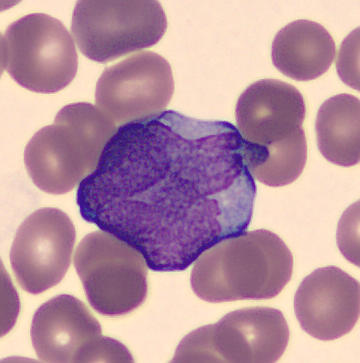 
Unidentified 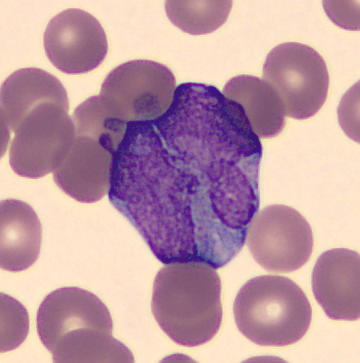 
Blast 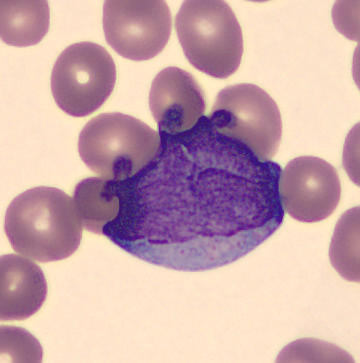

In [73]:
signed[(signed.label =='PMO')]#& (df.cell_type=='Blast, no lineage spec')]

,img_paths,id,label,cell_type,patient
918,../data/PBC_dataset_APL_AML/Patient_74/Signed ...,7383852,PMO,Promonocyte,Patient_74
1007,../data/PBC_dataset_APL_AML/Patient_74/Signed ...,7383852,PMO,"Blast, no lineage spec",Patient_74
1265,../data/PBC_dataset_APL_AML/Patient_45/Signed ...,8476534,PMO,Promonocyte,Patient_45
1266,../data/PBC_dataset_APL_AML/Patient_45/Signed ...,8476521,PMO,Promonocyte,Patient_45
1267,../data/PBC_dataset_APL_AML/Patient_45/Signed ...,8476619,PMO,Promonocyte,Patient_45
...,...,...,...,...,...
14413,../data/PBC_dataset_APL_AML/Patient_09/Signed ...,15759431,PMO,Promonocyte,Patient_09
14414,../data/PBC_dataset_APL_AML/Patient_09/Signed ...,15759432,PMO,Promonocyte,Patient_09
14415,../data/PBC_dataset_APL_AML/Patient_09/Signed ...,15759394,PMO,Promonocyte,Patient_09
14416,../data/PBC_dataset_APL_AML/Patient_09/Signed ...,15759442,PMO,Promonocyte,Patient_09


In [103]:
signed.loc[3067]

img_paths    ../data/PBC_dataset_APL_AML/Patient_20/Signed ...
id                                                    11617707
label                                                       LY
cell_type                                           Lymphocyte
patient                                             Patient_20
Name: 3067, dtype: object

In [101]:
np.array([path.stat().st_size for path in path.rglob(f'{training_glob}/*/*.jpg')]).argmin()

3067

# TO DO clean up cell

### Import images and store as a list of array

`SMU_8371935.jpg`, `LY_8338724.jpg` are broken removed from df

In [115]:
signed = signed[~(signed['id'].isin(['8371935', '8338724']))]

In [117]:
for i, file in enumerate(signed['img_paths']):
    print(file)
    io.imread(file)
                        

../data/PBC_dataset_APL_AML/Patient_48/Signed slides/Erythroblast/ERB_13828414.jpg
../data/PBC_dataset_APL_AML/Patient_48/Signed slides/Erythroblast/ERB_13828371.jpg
../data/PBC_dataset_APL_AML/Patient_48/Signed slides/Erythroblast/ERB_13828375.jpg
../data/PBC_dataset_APL_AML/Patient_48/Signed slides/Erythroblast/ERB_13828478.jpg
../data/PBC_dataset_APL_AML/Patient_48/Signed slides/Erythroblast/ERB_13828494.jpg
../data/PBC_dataset_APL_AML/Patient_48/Signed slides/Erythroblast/ERB_13828485.jpg
../data/PBC_dataset_APL_AML/Patient_48/Signed slides/Erythroblast/ERB_13828402.jpg
../data/PBC_dataset_APL_AML/Patient_48/Signed slides/Erythroblast/ERB_13828444.jpg
../data/PBC_dataset_APL_AML/Patient_48/Signed slides/Erythroblast/ERB_13828474.jpg
../data/PBC_dataset_APL_AML/Patient_48/Signed slides/Erythroblast/ERB_13828460.jpg
../data/PBC_dataset_APL_AML/Patient_48/Signed slides/Erythroblast/ERB_13828457.jpg
../data/PBC_dataset_APL_AML/Patient_48/Signed slides/Erythroblast/ERB_13828477.jpg
../d

ValueError: Could not load "" 
Reason: "image file is truncated (19 bytes not processed)"
Please see documentation at: http://pillow.readthedocs.io/en/latest/installation.html#external-libraries

In [116]:
%time
images = {i: io.imread(file) for i, file in enumerate(signed['img_paths'])}

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


ValueError: Could not load "" 
Reason: "image file is truncated (19 bytes not processed)"
Please see documentation at: http://pillow.readthedocs.io/en/latest/installation.html#external-libraries

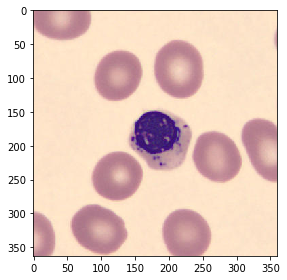

In [94]:
io.imshow(signed.img_paths[0])

In [91]:
len(images)

NameError: name 'images' is not defined

### Add height, width and brightness to df

In [73]:
df['height'] = [im.shape[0] for im in images]
df['width'] = [im.shape[1] for im in images]

In [166]:
df['mean_brightness'] = [np.mean(im) for im in images]

In [170]:
df.to_csv('../data/PBC_dataset_normal_df.csv', index=False)